## Setup

In [ ]:
import os
import sys
import random

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
import numpy as np

sys.path.append("../src")

import models  # noqa: E402
import utils  # noqa: E402
import train.backprop  # noqa: E402
import train.ff  # noqa: E402

In [ ]:
# Config

batch_size = 32
n_classes = 10
lr = 0.001
n_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
# Load data

train_loader, val_loader, test_loader = utils.load_mnist_data(batch_size)
class_names = [str(i) for i in range(n_classes)]

100.0%
100.0%
100.0%
100.0%


## Backprop

In [5]:
# Initialize model, loss, optimizer
model = models.LeNet5(n_classes=n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

n_params = sum(p.numel() for p in model.parameters())
torchinfo.summary(model, input_size=(batch_size, 1, 32, 32))
print("")

# Train model using backpropagation
history = train.backprop.backprop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=n_epochs,
    device=device,
)

# Save trained model
save_path = "results/backprop-model.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"\nTraining completed. Model saved to '{save_path}'")

# Save training history
dst = "results/backprop-history.csv"
pd.DataFrame(history).to_csv(dst, index=False)

# Evaluate model
test_metrics = train.backprop.evaluate(model, test_loader, criterion, device)
utils.save_metrics(test_metrics, "results/mnist-metrics.csv", "backprop")

# Final summary
print("\nBackpropagation – Training Summary")
print("-" * 60)
print(f"Train accuracy: {history['train_accuracies'][-1]:.2f}%")
print(f"Val accuracy: {history['val_accuracies'][-1]:.2f}%")
print(f"Test accuracy: {test_metrics['accuracy']:.2f}%")
print(f"Params: {n_params:,}")
print(f"Epochs: {n_epochs}")


Starting backpropagation training for 5 epochs
------------------------------------------------------------
Epoch: [1/5]  Train Loss: 0.2158,  Train Acc:  93.42%,  Val Loss: 0.0896,  Val Acc:   0.97%,  Time:  9.92s
Epoch: [2/5]  Train Loss: 0.0705,  Train Acc:  97.83%,  Val Loss: 0.0812,  Val Acc:   0.98%,  Time:  9.68s
Epoch: [3/5]  Train Loss: 0.0501,  Train Acc:  98.49%,  Val Loss: 0.0586,  Val Acc:   0.98%,  Time: 10.34s
Epoch: [4/5]  Train Loss: 0.0376,  Train Acc:  98.84%,  Val Loss: 0.0546,  Val Acc:   0.99%,  Time: 10.12s
Epoch: [5/5]  Train Loss: 0.0312,  Train Acc:  99.01%,  Val Loss: 0.0619,  Val Acc:   0.98%,  Time:  9.99s

Training completed. Model saved to 'results/backprop-model.pth'

Backpropagation – Training Summary
------------------------------------------------------------
Train accuracy: 99.01%
Val accuracy: 0.98%
Test accuracy: 0.99%
Params: 61,706
Epochs: 5


## Forward-forward

In [6]:
# Initialize model, loss, optimizer
model = models.FFLeNet5(n_classes=n_classes)
optimizers = [torch.optim.Adam(layer.parameters(), lr=lr) for layer in model.layers]

n_params = sum(p.numel() for p in model.parameters())
torchinfo.summary(model, input_size=(batch_size, 1 + n_classes, 32, 32))
print("")

# Train model using forward-forward
# - No criterion: FF does not use global loss
# - No optimizer: FF uses per-layer optimizers
history = train.ff.forward_forward(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizers=optimizers,
    n_epochs=n_epochs,
    device=device,
    n_classes=n_classes,
    threshold=2.0,
)

# Save trained model
save_path = "results/ff-model.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"\nTraining completed. Model saved to '{save_path}'")

# Save training history
dst = "results/ff-history.csv"
pd.DataFrame(history).to_csv(dst, index=False)

# Evaluate model
test_metrics = train.ff.evaluate(model, test_loader, n_classes, device)
utils.save_metrics(test_metrics, "results/mnist-metrics.csv", "ff")

# Final summary
print("\nForward-Forward – Training Summary")
print("-" * 60)
print(f"Train accuracy: {history['train_accuracies'][-1]:.2f}%")
print(f"Val accuracy: {history['val_accuracies'][-1]:.2f}%")
print(f"Test accuracy: {test_metrics['accuracy']:.2f}%")
print(f"Params: {n_params:,}")
print(f"Epochs: {n_epochs}")


Starting forward-forward training for 5 epochs
------------------------------------------------------------
Epoch: [1/5]  Train Loss: 3.9720,  Train Acc:   0.00%,  Val Acc:   0.89%,  Time: 34.16s
Epoch: [2/5]  Train Loss: 2.3532,  Train Acc:   0.00%,  Val Acc:   0.90%,  Time: 35.06s
Epoch: [3/5]  Train Loss: 1.9517,  Train Acc:   0.00%,  Val Acc:   0.91%,  Time: 34.34s
Epoch: [4/5]  Train Loss: 1.7597,  Train Acc:   0.00%,  Val Acc:   0.88%,  Time: 35.81s
Epoch: [5/5]  Train Loss: 1.5243,  Train Acc:   0.00%,  Val Acc:   0.92%,  Time: 34.55s

Training completed. Model saved to 'results/ff-model.pth'

Forward-Forward – Training Summary
------------------------------------------------------------
Train accuracy: 0.00%
Val accuracy: 0.92%
Test accuracy: 0.94%
Params: 63,206
Epochs: 5


## Results

In [26]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_training_curves(
    histories: dict[str, pd.DataFrame],
    metrics: list[str] = ["losses"],
    save_path: str = None,
    title: str = "Training Curves",
):
    plt.figure(figsize=(10, 6))

    colors = plt.get_cmap("tab10")
    model_colors = {model_name: colors(i) for i, model_name in enumerate(histories)}

    line_styles = {"train": "-", "val": "--"}

    for model_name, df in histories.items():
        for metric in metrics:
            for phase in ["train", "val"]:
                col = f"{phase}_{metric}"
                if col in df.columns:
                    plt.plot(
                        df[col],
                        label=f"{model_name} ({phase})",
                        color=model_colors[model_name],
                        linestyle=line_styles[phase],
                    )

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Saved plot to {save_path}")
    else:
        plt.show()


def plot_test_metrics(csv_path: str, save_path: str = None):
    """
    Plot bar chart of test metrics from CSV.

    Args:
        csv_path: Path to mnist-metrics.csv
        save_path: If set, saves the figure instead of showing it.
    """
    df = pd.read_csv(csv_path)
    metric_cols = ["accuracy", "precision", "recall", "f1_score"]

    df_plot = df.set_index("model")[metric_cols]

    df_plot.plot(kind="bar", figsize=(10, 5))
    plt.title("Final Test Performance")
    plt.ylabel("Score")
    plt.ylim(0, 1.0)
    plt.grid(True, axis="y")
    plt.xticks(rotation=0)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Saved test performance plot to {save_path}")
    else:
        plt.show()

Saved plot to ../results/training-curves.png


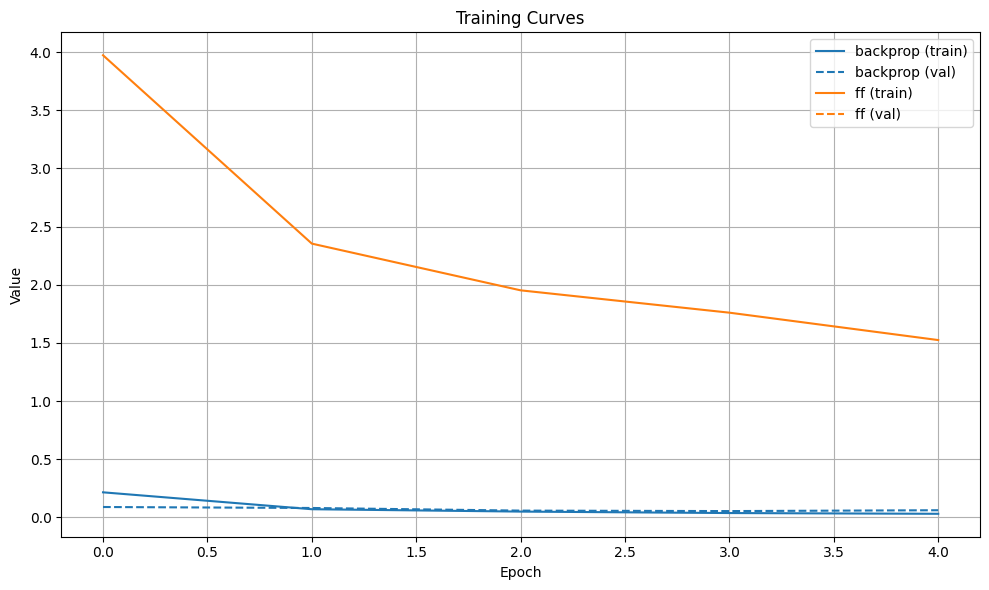

In [27]:
history_backprop = pd.read_csv("results/backprop-history.csv")
history_ff = pd.read_csv("results/ff-history.csv")

plot_training_curves(
    {"backprop": history_backprop, "ff": history_ff},
    save_path="../results/training-curves.png",
)
# plot_test_metrics("mnist-metrics.csv", save_path="../results/test-performance.png")